In [2]:
import numpy as np
import healpy as hp
from lsd2 import registry as reg
from dask.distributed import Client

In [3]:

#viewing imported hipscats
HIPS_DIR ='/data3/epyc/projects3/ivoa_demo/'
lsd2_registry = reg.Registry(location=HIPS_DIR)

Available HiPSCats:
   gaia
   des_y1a1
   ztf_dr14
   sdss


In [ ]:
#loading a hipscat
gaia = lsd2_registry.load_hipscat('gaia')
gaia.hips_metadata

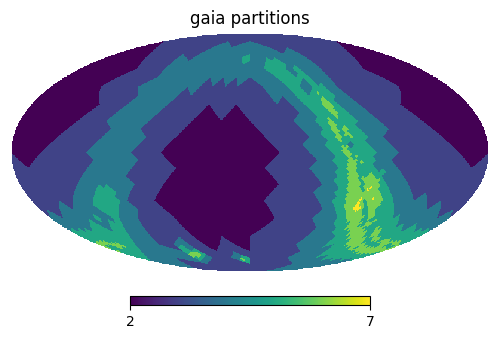

In [7]:
#basic catalog visualization
gaia.visualize_partitions()

In [8]:
#print the gaia columns
gaia.columns()

Index(['solution_id', 'designation', 'source_id', 'random_index', 'ref_epoch',
       'ra', 'ra_error', 'dec', 'dec_error', 'parallax',
       ...
       'ag_gspphot', 'ag_gspphot_lower', 'ag_gspphot_upper',
       'ebpminrp_gspphot', 'ebpminrp_gspphot_lower', 'ebpminrp_gspphot_upper',
       'libname_gspphot', 'Norder', 'Npix', 'Dir'],
      dtype='object', length=155)

In [9]:
#Performing distributed computations. Under the hood lsdb relies on the dask
# distributed client

#This is a directory dask can write its scratch directories too
DASK_CLIENT_DIR='/data3/epyc/projects3/ivoa_demo/'
client = Client(local_directory=DASK_CLIENT_DIR, n_workers=24, threads_per_worker=1)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 24
Total threads: 24,Total memory: 0.98 TiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:40395,Workers: 24
Dashboard: http://127.0.0.1:8787/status,Total threads: 24
Started: Just now,Total memory: 0.98 TiB
Comm: tcp://127.0.0.1:40489,Total threads: 1
Dashboard: http://127.0.0.1:40246/status,Memory: 41.98 GiB
Nanny: tcp://127.0.0.1:33490,


In [14]:
#create a new column and query based off the result
gaia_df = gaia.load(columns=['ra', 'dec', 'pmra', 'pmdec'])
gaia_df.assign(
    pm=lambda x: np.sqrt(x['pmra']**2 + x['pmdec']**2)
).query(
    'pm > 20'
).compute()

,ra,dec,pmra,pmdec,pm
_hipscat_index,,,,,
8080583678654152706,268.594230,-37.161300,-14.161059,-14.532952,20.291434
8080583700128989188,268.586248,-37.157506,16.309003,17.515559,23.932789
8080583820388073481,268.578893,-37.148654,20.260327,13.100662,24.126918
8080584215525064707,268.577111,-37.135510,-14.241277,-17.609755,22.647681
8080584267064672261,268.590730,-37.119633,-25.869415,-22.354809,34.190117
...,...,...,...,...,...
10160118873857196032,44.914825,-19.551427,-13.684613,-37.293795,39.725254
10160119780095295488,45.021199,-19.520210,25.067538,-1.876388,25.137667
10160120209592025088,44.969299,-19.517549,104.769598,-55.100795,118.375531


In [17]:
#Perform Spatial Analysis: Cone Searches
gaia.cone_search(
    ra=30,
    dec=30,
    radius=10,
    columns=['ra', 'dec', 'pmra', 'pmdec']
).assign(
    pm=lambda x: np.sqrt(x['pmra']**2 + x['pmdec']**2)
).query(
    'pm > 20'
).compute()

,ra,dec,pmra,pmdec,source_id,_DIST,pm
_hipscat_index,,,,,,,
632131431199408128,22.501507,35.711008,42.822473,0.712269,322007476436670080,8.497228,42.828396
632132285897900032,22.481552,35.733150,44.003818,-6.299540,322007686890806784,8.523885,44.452449
632132492056330240,22.481811,35.740666,0.139768,-25.880201,322007751314580608,8.528570,25.880579
632132900078223360,22.548769,35.745291,31.163334,0.100033,322007923113272960,8.490131,31.163495
632133900805603328,22.558643,35.802162,-32.746894,-33.278669,322008369789880320,8.521092,46.688638
...,...,...,...,...,...,...,...
287846367420743680,39.653902,35.772823,26.824466,-31.984724,141117167761288960,9.943599,41.744156
287846616528846850,39.683174,35.801052,27.811011,-6.407153,141117335264396800,9.978845,28.539515
287851233618690048,39.618819,35.879694,19.408846,-34.659944,141121462728568192,9.978059,39.724238


In [28]:
#Perform Spatial Analysis: Cross Match
ztf = lsd2_registry.load_hipscat('ztf_dr14')
gaia.cross_match(ztf,
        c1_cols=['ra', 'dec', 'pmra', 'pmdec'],
        c2_cols=['ps1_objid', 'nobs_g', 'nobs_r', 'nobs_i']
).compute()


,gaia.ra,gaia.dec,gaia.pmra,gaia.pmdec,gaia.source_id,ztf_dr14.ps1_objid,ztf_dr14.nobs_g,ztf_dr14.nobs_r,ztf_dr14.nobs_i,ztf_dr14.ra,ztf_dr14.dec,hips_k,hips_pix,_DIST,_hipscat_index
0,265.916539,-24.484689,NaN,NaN,4068301324842843776,78612659168359032,0,185,0,265.917023,-24.484314,7,115628,0.000578,8136597194724605953
1,265.978383,-24.420640,NaN,NaN,4068307509588747008,78692659784195639,8,0,0,265.978516,-24.420774,7,115628,0.000181,8136597216199442435
2,265.921978,-24.492969,NaN,NaN,4068113651788285312,78602659220248777,111,392,0,265.921982,-24.493016,7,115628,0.000048,8136597293508853769
3,265.763623,-24.579447,1.477686,-1.785524,4068298889556183040,78502657636715043,3,346,0,265.763718,-24.579455,7,115628,0.000087,8136597177544736770
4,265.731315,-24.574802,NaN,NaN,4068299679694650752,78512657315250814,35,390,0,265.731461,-24.574647,7,115628,0.000204,8136597194724605959
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
612125,50.124317,-25.085765,10.033175,2.283007,5074017605503248896,77890501257990744,184,175,0,50.125820,-25.091307,3,561,0.005706,10148035232478003200
612138,50.167639,-25.048844,142.453934,-67.730194,5074018155259061760,77940501725252955,0,2,0,50.172710,-25.047728,3,561,0.004728,10148036319104729088
612639,50.312132,-24.916528,24.404773,10.647199,5074044023845477248,78100503171520501,0,1,0,50.317501,-24.916435,3,561,0.004871,10148088064870711296
612640,50.309078,-24.917567,3.546417,-3.010719,5074044023845476736,78100503171520501,0,1,0,50.317501,-24.916435,3,561,0.007722,10148088051985809408


In [30]:
#Concatenating Spatial Analysis: ConeSearch + CrossMatch
gaia.cone_search(
    ra = 30,
    dec = 30,
    radius=10
).cross_match(
    ztf,
    c1_cols=['ra', 'dec', 'pmra', 'pmdec'],
    c2_cols=['ps1_objid', 'nobs_g', 'nobs_r', 'nobs_i']
).assign(
    pm=lambda x: np.sqrt(x['gaia.pmra']**2 + x['gaia.pmdec']**2)
).query(
    'pm > 20'
).compute()

,gaia.ra,gaia.dec,gaia.pmra,gaia.pmdec,gaia.source_id,ztf_dr14.ps1_objid,ztf_dr14.nobs_g,ztf_dr14.nobs_r,ztf_dr14.nobs_i,ztf_dr14.ra,ztf_dr14.dec,hips_k,hips_pix,_DIST,_hipscat_index,pm
3,44.999590,19.472177,95.108632,-17.776062,108086395352097152,131360449999346838,342,579,0,44.999923,19.472019,3,12,0.000351,216173172955807744,96.755570
4,45.000071,19.471897,95.032176,-17.965723,108086395352607872,131360449999346838,342,579,0,44.999923,19.472019,3,12,0.000185,216173336164564992,96.715468
29,45.019053,19.553340,20.154311,-5.232329,108087323064952960,131460450190204595,6,283,0,45.019025,19.553342,3,12,0.000027,216175350504226816,20.822429
33,44.940686,19.543408,36.766822,-24.060011,108087765446451072,131450449406172660,114,146,0,44.940696,19.543406,3,12,0.000010,216175560957624320,43.939542
34,44.990565,19.550461,18.602594,-9.896639,108087666662877952,131460449905191104,335,568,0,44.990567,19.550473,3,12,0.000012,216175711281479680,21.071306
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
447496,32.707553,18.544011,20.857033,-10.265711,92921961046752640,130240327147449135,0,37,5,32.714704,18.540428,3,8,0.007668,185843947862491136,23.246519
447516,32.774098,18.599365,37.056002,-28.809199,92922652536715904,130310327757820623,0,125,24,32.775754,18.591794,3,8,0.007732,185845300777189376,46.937375
449761,33.079895,18.872473,70.600279,-10.207492,93027651601576064,130630330824368293,0,1,0,33.082348,18.864983,3,8,0.007841,186055303203127296,71.334370
449845,33.183592,18.966775,16.749201,-43.659638,93030228582086272,130750331897163955,3,28,0,33.189733,18.961166,3,8,0.008074,186060474343751680,46.762161


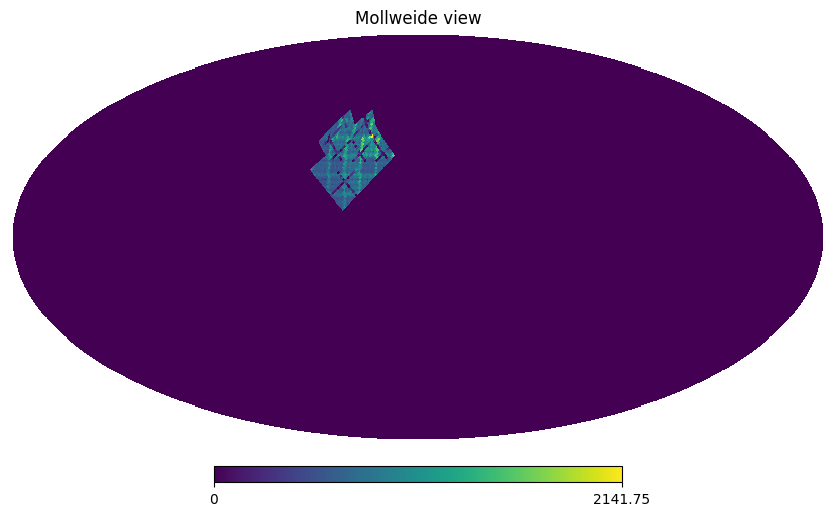

In [31]:
#visualizing a result, weight the output based on a column

img = gaia.cone_search(
    ra = 30,
    dec = 30,
    radius=10
).cross_match(
    ztf,
    c1_cols=['ra', 'dec', 'pmra', 'pmdec'],
    c2_cols=['ps1_objid', 'nobs_g', 'nobs_r', 'nobs_i']
).assign(
    pm=lambda x: np.sqrt(x['gaia.pmra']**2 + x['gaia.pmdec']**2),
    count_obsv=lambda x: x['ztf_dr14.nobs_g'] + x['ztf_dr14.nobs_r'] + x['ztf_dr14.nobs_i']
).query(
    'pm > 20'
).skymap(
    col='count_obsv',
    spatial_kws = ('gaia.ra', 'gaia.dec')
)

hp.mollview(img, nest=True)

In [32]:
client.close()